In [1]:
#Importa librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima
import pickle  



DATA COLLECTION

Datos de Yahoo Finance

In [2]:
sp500 = yf.Ticker("^GSPC")
gold = yf.Ticker("^GC=F")
oil= yf.Ticker("CL=F")
brent= yf.Ticker("BZ=F")

Para el Sp500 utilizo los datos a partir del año 2000, ya que en años anteriores la composición por industria del SP500 era bastante diferente. A partir de ese año hay importnate participación del sector teconología. Hago lo mismo para las otras variables

In [3]:
start_date = '2000-01-01'
end_date = '2024-04-26'

sp500 = sp500.history(period="max")
sp500 =sp500.loc[start_date:end_date].copy ()
oil = oil.history(period="max")
oil = oil.loc[start_date:end_date].copy ()
brent = brent.history(period="max") 
brent = brent.loc[start_date:end_date:].copy ()


In [4]:
sp500.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03 00:00:00-05:00,1469.250000,1478.000000,1438.359985,1455.219971,931800000,0.0,0.0
2000-01-04 00:00:00-05:00,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,0.0,0.0
2000-01-05 00:00:00-05:00,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,0.0,0.0
2000-01-06 00:00:00-05:00,1402.109985,1411.900024,1392.099976,1403.449951,1092300000,0.0,0.0
2000-01-07 00:00:00-05:00,1403.449951,1441.469971,1400.729980,1441.469971,1225200000,0.0,0.0


In [5]:
sp500 = sp500.drop(columns=['Dividends', 'Stock Splits'])
sp500.index= sp500.index.tz_localize(None) # remove timezone

In [6]:
#Guardar el dataset en un archivo csv   
sp500.to_csv('sp500.csv', index=True)

In [7]:
#Hago lo mismo con el resto de los activos
oil = oil.drop(columns=['Dividends', 'Stock Splits', 'Open', 'High', 'Low', 'Volume'])
oil.index= oil.index.tz_localize(None) # remove timezone
oil.head()

,Close
Date,
2000-08-23,32.049999
2000-08-24,31.629999
2000-08-25,32.049999
2000-08-28,32.869999
2000-08-29,32.720001


In [8]:
# Renombo la columna 'Close' a 'Close_oil' en el DataFrame 'oil' para que no se confunda con la del S&P 500
oil.rename(columns={'Close': 'Close_oil'}, inplace=True)

# Muestra las primeras filas para verificar el cambio
print(oil.head())


            Close_oil
Date                 
2000-08-23  32.049999
2000-08-24  31.629999
2000-08-25  32.049999
2000-08-28  32.869999
2000-08-29  32.720001


In [9]:
# Asumiendo que 'df' es tu DataFrame y 'oil' es la columna con los datos de precios de petróleo
oil['oil_daily_changes'] = oil['Close_oil'].pct_change() * 100  # Multiplicar por 100 para convertir a porcentaje


Datos de FRED (Banco de la Reserva Federal de St. Louis)

In [10]:
import requests


# FRED API endpoint
url = "https://api.stlouisfed.org/fred/series/observations"

# List of series IDs to be downloaded
# CREDIT RISK AND RISK APPETITE VARIABLES # OJO --->>>> Estas variables miden el riesgo de crédito y el apetito por el riesgo de los inversores 

# DAAA = Moody's Seasoned Aaa Corporate Bond Yield
# AAA10Y = Moody's Seasoned Aaa Corporate Bond Yield Relative to Yield on 10-Year Treasury Constant Maturity
# DBAA = Moody's Seasoned Baa Corporate Bond Yield
# BAA10Y = Moody's Seasoned Baa Corporate Bond Yield Relative to Yield on 10-Year Treasury Constant Maturity
# BAMLH0A0HYM2 = ICE BofA US High Yield Index Option-Adjusted Spread 
# BAMLH0A2HYB = ICE BofA Single-B US High Yield Index Option-Adjusted Spread 
# BAMLH0A3HYC = ICE BofA CCC & Lower US High Yield Index Option-Adjusted Spread
# BAMLHE00EHYIOAS = ICE BofA Euro High Yield Index Option-Adjusted Spread -  

# INTEREST RATE VARIABLES
#OJO --->>>> Esta variables miden el cambio en las expectativas de inflación y los movimientos de tasas de interés

# T10Y2Y = 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity
# T10Y3M = 10-Year Treasury Constant Maturity Minus 3-Month Treasury Constant Maturity  
# T5YIE = 5-Year Breakeven Inflation Rate (Expected Inflation Rate) - 5-Year 

# EXCHANGE RATES Vs main commercial partners for the U.S.
# DEXUSEU = U.S. Dollars to Euro Spot Exchange Rate - value of one U.S. Dollar in Euros
# DEXCHUS = Chinese Yuan Renminbi to U.S. Dollar Spot Exchange Rate - value of one Chinese Yuan Renminbi in U.S. Dollars
# DEXCAUS = Canadian Dollars to U.S. Dollar Spot Exchange Rate - value of one Canadian Dollar in U.S. Dollars
# DEXMXUS= Mexican Pesos to U.S. Dollar Spot Exchange Rate - value of one Mexican Peso in U.S. Dollars

# VOLATILITY INDECES (MARKET EXPECTATION OF NEAR TERM VOLATILITY)
# VIXCLS = CBOE Volatility Index - VIX measures market expectation of near term volatility conveyed by stock index option prices.
#(GVZCLS)= CBOE Gold ETF Volatility Index 

series_ids = ['DAAA','AAA10Y','DBAA','BAA10Y','BAMLH0A0HYM2','BAMLH0A2HYB','BAMLH0A3HYC','BAMLHE00EHYIOAS','T10Y2Y','T10Y3M','T5YIE','DEXUSEU','DEXCHUS','DEXCAUS','DEXMXUS','VIXCLS','GVZCLS']

# Your FRED API key
api_key = '7de04d83472c6affd4e0a1505211d3b9'

# Initialize an empty dictionary to store DataFrames
dfs = {}

# Loop through each series ID
for series_id in series_ids:
    # API parameters
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
    }
    
    # Make the API request
    response = requests.get(url, params=params)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Convert the response to JSON
        data = response.json()
        # Extract data for DataFrame
        dates = [item['date'] for item in data['observations']]
        values = [item['value'] for item in data['observations']]
        # Create DataFrame and convert types
        temp_df = pd.DataFrame({'Date': dates, series_id: values})
        temp_df['Date'] = pd.to_datetime(temp_df['Date'])
        temp_df[series_id] = pd.to_numeric(temp_df[series_id], errors='coerce')
        # Add the DataFrame to the dictionary
        dfs[series_id] = temp_df.set_index('Date')
    else:
        print(f"Failed to retrieve data for {series_id}: {response.status_code}")

# Combine all the series DataFrames into one DataFrame 
macroeconomic_df = pd.concat(dfs.values(), axis=1)




In [11]:
#Sacar los cambios diarios de las variables macroeconomicas
changes_daily = macroeconomic_df.diff()

# Renombrar las columnas para indicar que representan cambios diarios
changes_daily.columns = [f"{col}_daily_change" for col in macroeconomic_df.columns]

# Concatenar los cambios diarios de vuelta al DataFrame original
macroeconomic_df = pd.concat([macroeconomic_df, changes_daily], axis=1)

In [12]:
# Contar los valores nulos en cada columna
null_counts_macro = macroeconomic_df.isnull().sum()
print("Conteo de valores nulos por columna antes de limpiar:\n", null_counts_macro)

# Eliminar las filas con valores nulos o NaN
macroeconomic_df_clean = macroeconomic_df.dropna()

# Contar de nuevo los valores nulos en cada columna
null_counts_clean = macroeconomic_df_clean.isnull().sum()
print("Conteo de valores nulos por columna después de limpiar:\n", null_counts_clean)

# Guardar el DataFrame limpio a un archivo CSV
macroeconomic_df_clean.to_csv("macroeconomic_df_clean.csv")


Conteo de valores nulos por columna antes de limpiar:
 DAAA                             3625
AAA10Y                           3674
DBAA                             4384
BAA10Y                           4421
BAMLH0A0HYM2                     6870
BAMLH0A2HYB                      6870
BAMLH0A3HYC                      6870
BAMLHE00EHYIOAS                  7127
T10Y2Y                           2028
T10Y3M                           3419
T5YIE                            8667
DEXUSEU                          7652
DEXCHUS                          3191
DEXCAUS                           625
DEXMXUS                          6363
VIXCLS                           5344
GVZCLS                           9997
DAAA_daily_change                4101
AAA10Y_daily_change              4198
DBAA_daily_change                4836
BAA10Y_daily_change              4909
BAMLH0A0HYM2_daily_change        6958
BAMLH0A2HYB_daily_change         6958
BAMLH0A3HYC_daily_change         6958
BAMLHE00EHYIOAS_daily_change     

In [13]:
# Unir macroeconomic_df con sp500 basado en sus índices de fecha
AllVar_df =sp500.join(macroeconomic_df_clean, how='inner')

print(AllVar_df.index)
AllVar_df = AllVar_df.sort_index()

DatetimeIndex(['2008-06-04', '2008-06-05', '2008-06-06', '2008-06-09',
               '2008-06-10', '2008-06-11', '2008-06-12', '2008-06-13',
               '2008-06-16', '2008-06-17',
               ...
               '2024-04-15', '2024-04-16', '2024-04-17', '2024-04-18',
               '2024-04-19', '2024-04-22', '2024-04-23', '2024-04-24',
               '2024-04-25', '2024-04-26'],
              dtype='datetime64[ns]', name='Date', length=3732, freq=None)


In [14]:
# Unir el DataFrame 'oil' al 'AllVar_df' que ya contiene datos combinados de 'macroeconomic_df' y 'sp500'
# Asegúrate de que 'oil' está indexado adecuadamente, si es necesario
if 'Date' in oil.columns:
    oil.set_index('Date', inplace=True)

# Especificando sufijos para resolver el conflicto de nombres de columnas
AllVar_df = AllVar_df.join(oil, how='inner', lsuffix='_AllVar', rsuffix='_oil')

# Mostrar las primeras filas para verificar las nuevas columnas
print(AllVar_df.head())

                   Open         High          Low        Close      Volume  \
Date                                                                         
2008-06-04  1376.260010  1388.180054  1371.739990  1377.199951  4338640000   
2008-06-05  1377.479980  1404.050049  1377.479980  1404.050049  4350790000   
2008-06-06  1400.060059  1400.060059  1359.900024  1360.680054  4771660000   
2008-06-09  1360.829956  1370.630005  1350.619995  1361.760010  4404570000   
2008-06-10  1358.979980  1366.839966  1351.560059  1358.439941  4635070000   

            DAAA  AAA10Y  DBAA  BAA10Y  BAMLH0A0HYM2  ...  \
Date                                                  ...   
2008-06-04  5.64    1.66  7.02    3.04          6.79  ...   
2008-06-05  5.69    1.63  7.07    3.01          6.63  ...   
2008-06-06  5.61    1.67  6.98    3.04          6.68  ...   
2008-06-09  5.58    1.56  6.96    2.94          6.58  ...   
2008-06-10  5.66    1.55  7.05    2.94          6.49  ...   

            T10Y3M_daily_

In [15]:
null_counts = AllVar_df.isnull().sum()
print("Conteo de valores nulos por columna:\n", null_counts)

start_date_All = AllVar_df.index.min()
end_date_All = AllVar_df.index.max()
print(f"Los datos comienzan el: {start_date_All}")
print(f"Los datos terminan el: {end_date_All}")

Conteo de valores nulos por columna:
 Open                            0
High                            0
Low                             0
Close                           0
Volume                          0
DAAA                            0
AAA10Y                          0
DBAA                            0
BAA10Y                          0
BAMLH0A0HYM2                    0
BAMLH0A2HYB                     0
BAMLH0A3HYC                     0
BAMLHE00EHYIOAS                 0
T10Y2Y                          0
T10Y3M                          0
T5YIE                           0
DEXUSEU                         0
DEXCHUS                         0
DEXCAUS                         0
DEXMXUS                         0
VIXCLS                          0
GVZCLS                          0
DAAA_daily_change               0
AAA10Y_daily_change             0
DBAA_daily_change               0
BAA10Y_daily_change             0
BAMLH0A0HYM2_daily_change       0
BAMLH0A2HYB_daily_change        0
BAMLH0A3HY

### IMPLEMENTACION PROPHET

In [16]:
from prophet import Prophet

In [17]:
# Definimos la fecha específica desde la cual queremos considerar los datos
start_date_or= '2014-04-30'
test_size_Control=0.2

# Seleccionamos los datos a partir de la fecha específica
SP500_Prophet = AllVar_df.loc[start_date_or:, 'Close']


In [18]:

SP500_Prophet = SP500_Prophet.reset_index()
SP500_Prophet = SP500_Prophet.rename(columns={'Date': 'ds', 'Close': 'y'})

In [19]:
SP500_Prophet.head()

,ds,y
0,2014-04-30,1883.949951
1,2014-05-01,1883.680054
2,2014-05-02,1881.140015
3,2014-05-05,1884.660034
4,2014-05-06,1867.719971


In [21]:
# Dividir los datos en conjuntos de entrenamiento y prueba
cutoff_prophet = int(len(SP500_Prophet) * (1-test_size_Control))
train_prophet = SP500_Prophet.iloc[:cutoff_prophet]
test_prophet = SP500_Prophet.iloc[cutoff_prophet:]



In [22]:
# Asumiendo que 'train_prophet' y 'test_prophet' son tus DataFrames que contienen la columna 'ds'

# Obtener el primer y último día del conjunto de entrenamiento
train_start = train_prophet['ds'].min()
train_end = train_prophet['ds'].max()

# Obtener el primer y último día del conjunto de prueba
test_start = test_prophet['ds'].min()
test_end = test_prophet['ds'].max()

print(f"Train Period: Start - {train_start}, End - {train_end}")
print(f"Test Period: Start - {test_start}, End - {test_end}")


Train Period: Start - 2014-04-30 00:00:00, End - 2022-04-28 00:00:00
Test Period: Start - 2022-04-29 00:00:00, End - 2024-04-26 00:00:00


In [23]:
# Ajustar el modelo Prophet
model = Prophet(daily_seasonality=False)
model.fit(train_prophet)

20:49:31 - cmdstanpy - INFO - Chain [1] start processing
20:49:33 - cmdstanpy - INFO - Chain [1] done processing


In [24]:

# Crear DataFrame para predicciones futuras igual al tamaño del conjunto de prueba
future_prophet = test_prophet[['ds']]

# Realizar predicciones
forecast_prophet = model.predict(future_prophet)

# Evaluar el modelo comparando 'forecast' con 'test'
mse_test = mean_squared_error(test_prophet['y'], forecast_prophet['yhat'])
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(test_prophet['y'], forecast_prophet['yhat'])
print(f'Test - MSE: {mse_test}, RMSE: {rmse_test}, MAE: {mae_test}')


Test - MSE: 1871640.7749605274, RMSE: 1368.0792283199564, MAE: 1348.215930733352


In [25]:
future_prophet.head()

,ds
1873,2022-04-29
1874,2022-05-03
1875,2022-05-04
1876,2022-05-05
1877,2022-05-06


In [26]:
forecast_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-04-29,4817.258641,4651.430291,4937.260163,4817.258641,4817.258641,-23.080023,-23.080023,-23.080023,3.201662,3.201662,3.201662,-26.281685,-26.281685,-26.281685,0.0,0.0,0.0,4794.178618
1,2022-05-03,4826.193966,4651.655547,4952.125544,4826.193966,4826.193966,-16.611527,-16.611527,-16.611527,4.441593,4.441593,4.441593,-21.053120,-21.053120,-21.053120,0.0,0.0,0.0,4809.582439
2,2022-05-04,4828.427797,4663.684962,4971.375150,4828.427797,4828.427797,-15.516232,-15.516232,-15.516232,4.357415,4.357415,4.357415,-19.873646,-19.873646,-19.873646,0.0,0.0,0.0,4812.911565
3,2022-05-05,4830.661628,4670.957381,4969.597578,4830.661628,4830.661628,-17.446059,-17.446059,-17.446059,1.303891,1.303891,1.303891,-18.749949,-18.749949,-18.749949,0.0,0.0,0.0,4813.215570
4,2022-05-06,4832.895460,4669.118676,4967.982329,4832.895460,4832.895460,-14.480215,-14.480215,-14.480215,3.201662,3.201662,3.201662,-17.681877,-17.681877,-17.681877,0.0,0.0,0.0,4818.415245


c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


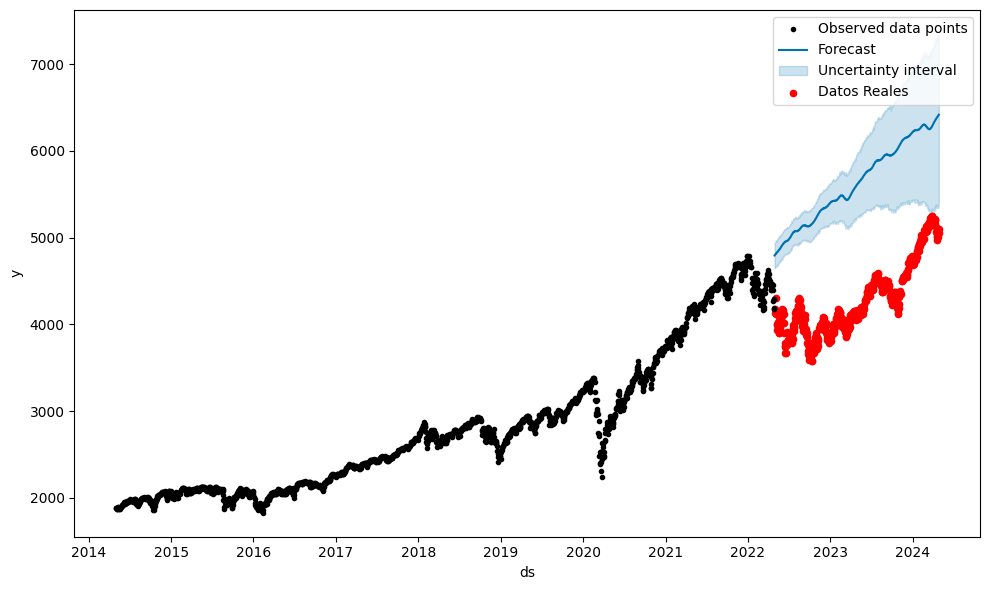

         dia  indice_real  indice_proyectado
0 2022-04-29  4131.930176        4794.178618
1 2022-05-03  4175.479980        4809.582439
2 2022-05-04  4300.169922        4812.911565
3 2022-05-05  4146.870117        4813.215570
4 2022-05-06  4123.339844        4818.415245


In [27]:
# Graficar resultados junto con los datos reales
fig = model.plot(forecast_prophet)
ax = fig.gca()
test_prophet.plot(kind='scatter', x='ds', y='y', color='red', ax=ax, label='Datos Reales')
ax.legend()

plt.show()

# Crear DataFrame con resultados solo para el período de prueba
resultados = pd.DataFrame({
    'dia': forecast_prophet['ds'],
    'indice_real': test_prophet['y'].reset_index(drop=True),
    'indice_proyectado': forecast_prophet['yhat']
})

# Formato del nombre del archivo que incluye variables dinámicas
nombre_archivo = f'resultados_prediccion_{start_date_or}_testSize_{test_size_Control}.csv'

# Guardar el DataFrame en un archivo CSV
resultados.to_csv(nombre_archivo, index=True)

# Mostrar los primeros resultados
print(resultados.head())


Agregando variables extenas

### Resultados me parecen raros (muy arriba)

In [28]:
# Obtén una lista con todos los nombres de las columnas en el DataFrame
column_names = AllVar_df.columns.tolist()
print("Nombres de columnas en AllVar_df:", column_names)


Nombres de columnas en AllVar_df: ['Open', 'High', 'Low', 'Close', 'Volume', 'DAAA', 'AAA10Y', 'DBAA', 'BAA10Y', 'BAMLH0A0HYM2', 'BAMLH0A2HYB', 'BAMLH0A3HYC', 'BAMLHE00EHYIOAS', 'T10Y2Y', 'T10Y3M', 'T5YIE', 'DEXUSEU', 'DEXCHUS', 'DEXCAUS', 'DEXMXUS', 'VIXCLS', 'GVZCLS', 'DAAA_daily_change', 'AAA10Y_daily_change', 'DBAA_daily_change', 'BAA10Y_daily_change', 'BAMLH0A0HYM2_daily_change', 'BAMLH0A2HYB_daily_change', 'BAMLH0A3HYC_daily_change', 'BAMLHE00EHYIOAS_daily_change', 'T10Y2Y_daily_change', 'T10Y3M_daily_change', 'T5YIE_daily_change', 'DEXUSEU_daily_change', 'DEXCHUS_daily_change', 'DEXCAUS_daily_change', 'DEXMXUS_daily_change', 'VIXCLS_daily_change', 'GVZCLS_daily_change', 'Close_oil', 'oil_daily_changes']


In [29]:
#Seleccionar las columnas que se van a utilizar
selected_columns = ['VIXCLS', 'BAMLH0A0HYM2_daily_change', 'BAMLH0A2HYB_daily_change','BAMLHE00EHYIOAS_daily_change', 'T5YIE_daily_change', 'DEXMXUS_daily_change', 'oil_daily_changes']

# Ahora crea un nuevo DataFrame con solo las columnas seleccionadas
X_Prophet = AllVar_df[selected_columns]


In [30]:
X_Prophet.head()

,VIXCLS,BAMLH0A0HYM2_daily_change,BAMLH0A2HYB_daily_change,BAMLHE00EHYIOAS_daily_change,T5YIE_daily_change,DEXMXUS_daily_change,oil_daily_changes
Date,,,,,,,
2008-06-04,20.80,0.01,0.05,0.08,-0.04,0.030,-1.616921
2008-06-05,18.63,-0.16,-0.17,-0.15,0.05,-0.008,4.488960
2008-06-06,23.56,0.05,0.04,-0.01,0.08,0.056,8.412233
2008-06-09,23.12,-0.10,-0.09,-0.06,0.03,-0.004,-3.024388
2008-06-10,23.18,-0.09,-0.09,0.17,0.00,0.024,-2.262753


In [31]:
# Asumiendo que ya tienes un DataFrame llamado 'X_Prophet' con tus variables exógenas y el índice es la columna 'Date'

# Paso 1: Convertir el índice a una columna
X_Prophet.reset_index(inplace=True)

# Paso 2: Renombrar la columna del índice como 'ds'
X_Prophet.rename(columns={'Date': 'ds'}, inplace=True)

# Paso 3: Combinar con tu DataFrame principal (SP500_Prophet)
SP500_Prophet_X = SP500_Prophet.merge(X_Prophet, on='ds', how='left')

# Ahora SP500_Prophet contiene las variables exógenas que puedes utilizar en el modelo Prophet


C:\Users\lgarn\AppData\Local\Temp\ipykernel_9640\3726500076.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_Prophet.rename(columns={'Date': 'ds'}, inplace=True)


In [32]:
SP500_Prophet_X.head()

,ds,y,VIXCLS,BAMLH0A0HYM2_daily_change,BAMLH0A2HYB_daily_change,BAMLHE00EHYIOAS_daily_change,T5YIE_daily_change,DEXMXUS_daily_change,oil_daily_changes
0,2014-04-30,1883.949951,13.41,0.05,0.00,0.10,0.01,-0.0320,-1.520538
1,2014-05-01,1883.680054,13.25,0.04,0.03,-0.01,0.00,-0.0310,-0.320834
2,2014-05-02,1881.140015,12.91,-0.02,-0.01,0.00,-0.01,-0.0540,0.341988
3,2014-05-05,1884.660034,13.29,0.01,0.01,-0.02,-0.03,0.0095,-0.280672
4,2014-05-06,1867.719971,13.80,-0.02,-0.03,0.00,-0.01,-0.0055,0.020101


In [33]:
# Dividir los datos en conjuntos de entrenamiento y prueba
#cutoff_prophet = int(len(SP500_Prophet_X) * 0.8)
train_prophet_X = SP500_Prophet_X.iloc[:cutoff_prophet]
test_prophet_X = SP500_Prophet_X.iloc[cutoff_prophet:]

In [34]:
# Asumiendo que 'train_prophet' y 'test_prophet' son tus DataFrames que contienen la columna 'ds'

# Obtener el primer y último día del conjunto de entrenamiento
train_start_X = train_prophet_X['ds'].min()
train_end_X = train_prophet_X['ds'].max()

# Obtener el primer y último día del conjunto de prueba
test_start_X = test_prophet_X['ds'].min()
test_end_X = test_prophet_X['ds'].max()

print(f"Train Period: Start - {train_start_X}, End - {train_end_X}")
print(f"Test Period: Start - {test_start_X}, End - {test_end_X}")


Train Period: Start - 2014-04-30 00:00:00, End - 2022-04-28 00:00:00
Test Period: Start - 2022-04-29 00:00:00, End - 2024-04-26 00:00:00


20:53:31 - cmdstanpy - INFO - Chain [1] start processing
20:53:31 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


Test - MSE: 1730816.592445638, RMSE: 1315.605029043914, MAE: 1288.4726464481932


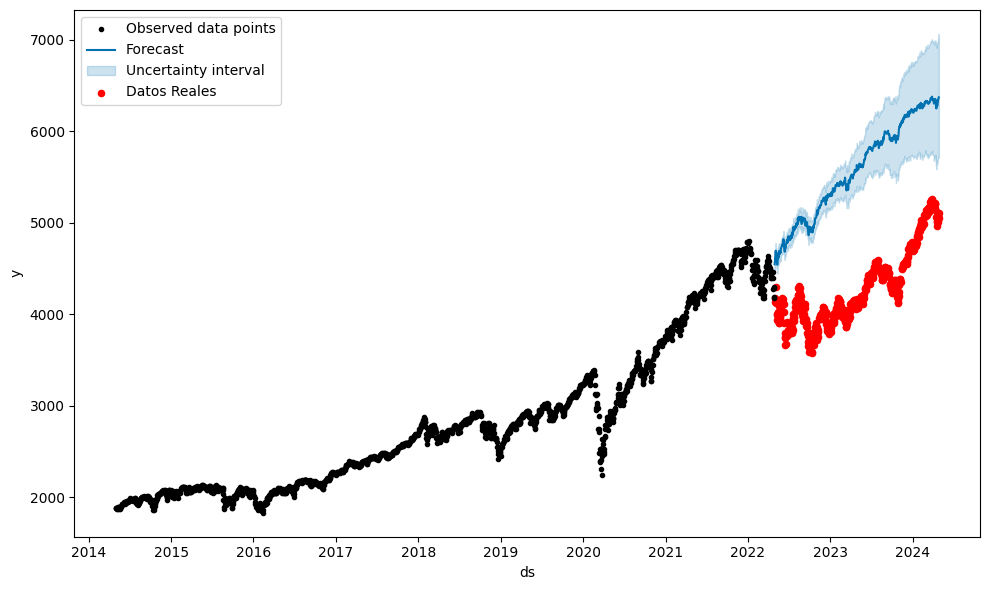

         dia  indice_real  indice_proyectado
0 2022-04-29  4131.930176        4544.560190
1 2022-05-03  4175.479980        4630.214844
2 2022-05-04  4300.169922        4692.869957
3 2022-05-05  4146.870117        4591.932897
4 2022-05-06  4123.339844        4629.765823


In [41]:
# Ajustar el modelo Prophet
model_prophet_X = Prophet(daily_seasonality=False)

# Agregar variables exógenas al modelo
for col in SP500_Prophet_X.columns:
    if col != 'ds' and col != 'y':  # No incluir la columna de fechas ni la variable dependiente 'y'
        model_prophet_X.add_regressor(col)

# Ajustar el modelo con los datos de entrenamiento
model_prophet_X.fit(train_prophet_X)

# Realizar predicciones
forecast_prophet_X = model_prophet_X.predict(test_prophet_X)

# Calcular errores de predicción
mse_test = mean_squared_error(test_prophet_X['y'], forecast_prophet_X['yhat'])
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(test_prophet_X['y'], forecast_prophet_X['yhat'])
print(f'Test - MSE: {mse_test}, RMSE: {rmse_test}, MAE: {mae_test}')

# Graficar resultados junto con los datos reales
fig = model.plot(forecast_prophet_X)
ax = fig.gca()
test_prophet_X.plot(kind='scatter', x='ds', y='y', color='red', ax=ax, label='Datos Reales')
ax.legend()

plt.show()

# Crear DataFrame con resultados solo para el período de prueba
resultados_Prophet_X = pd.DataFrame({
    'dia': forecast_prophet_X['ds'],
    'indice_real': test_prophet_X['y'].reset_index(drop=True),
    'indice_proyectado': forecast_prophet_X['yhat']
})

# Mostrar los primeros resultados
print(resultados_Prophet_X.head())

resultados_Prophet_X.to_csv('resultados_prediccion_Prophet_X_sp500.csv', index=True)

PROPHET CADA DIA

Prophet incorporando valores reales diarios conforme van ocurriendo

20:55:02 - cmdstanpy - INFO - Chain [1] start processing
20:55:02 - cmdstanpy - INFO - Chain [1] done processing
20:55:02 - cmdstanpy - INFO - Chain [1] start processing
20:55:02 - cmdstanpy - INFO - Chain [1] done processing
20:55:02 - cmdstanpy - INFO - Chain [1] start processing
20:55:03 - cmdstanpy - INFO - Chain [1] done processing
20:55:03 - cmdstanpy - INFO - Chain [1] start processing
20:55:03 - cmdstanpy - INFO - Chain [1] done processing
20:55:03 - cmdstanpy - INFO - Chain [1] start processing
20:55:04 - cmdstanpy - INFO - Chain [1] done processing
20:55:04 - cmdstanpy - INFO - Chain [1] start processing
20:55:04 - cmdstanpy - INFO - Chain [1] done processing
20:55:04 - cmdstanpy - INFO - Chain [1] start processing
20:55:05 - cmdstanpy - INFO - Chain [1] done processing
20:55:05 - cmdstanpy - INFO - Chain [1] start processing
20:55:05 - cmdstanpy - INFO - Chain [1] done processing
20:55:05 - cmdstanpy - INFO - Chain [1] start processing
20:55:06 - cmdstanpy - INFO - Chain [1]

Test - MSE: 194777.29045285878, RMSE: 441.3358023691923, MAE: 395.17338977760954


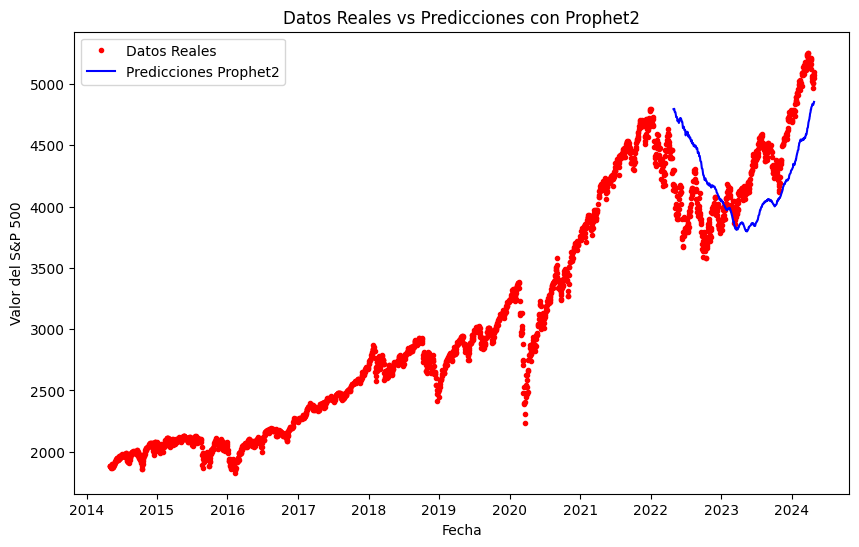

In [42]:
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np

# División en conjuntos de entrenamiento y prueba
train_size_prophet2 = int(len(SP500_Prophet) * (1-test_size_Control))
train_prophet2 = SP500_Prophet.iloc[:train_size_prophet2].copy()
test_prophet2 = SP500_Prophet.iloc[train_size_prophet2:].copy()

predictions_prophet2 = []
dates_for_plot_prophet2 = []

for index, row in test_prophet2.iterrows():
    # Crear un DataFrame para la próxima fecha
    future_prophet2 = pd.DataFrame([row['ds']], columns=['ds'])
    
    # Instanciar un nuevo modelo Prophet para cada iteración
    model_prophet2 = Prophet(daily_seasonality=False)
    model_prophet2.fit(train_prophet2[['ds', 'y']])
    
    # Realizar predicción para la próxima fecha
    forecast_prophet2 = model_prophet2.predict(future_prophet2)
    
    # Guardar la predicción
    predictions_prophet2.append(forecast_prophet2['yhat'].iloc[0])
    dates_for_plot_prophet2.append(row['ds'])
    
    # Agregar la observación real al DataFrame de entrenamiento para el próximo reentrenamiento
    train_prophet2 = pd.concat([train_prophet2, pd.DataFrame([row]).reset_index(drop=True)], ignore_index=True)

# Añadir predicciones al DataFrame de test para comparación
test_prophet2['predictions'] = predictions_prophet2

# Cálculo de métricas de error basadas en las predicciones actualizadas
mse_test_prophet2 = mean_squared_error(test_prophet2['y'], test_prophet2['predictions'])
rmse_test_prophet2 = np.sqrt(mse_test_prophet2)
mae_test_prophet2 = mean_absolute_error(test_prophet2['y'], test_prophet2['predictions'])

print(f'Test - MSE: {mse_test_prophet2}, RMSE: {rmse_test_prophet2}, MAE: {mae_test_prophet2}')

# Graficar los datos reales de todo el período y las predicciones
plt.figure(figsize=(10, 6))
plt.plot(SP500_Prophet['ds'], SP500_Prophet['y'], 'r.', label='Datos Reales')
plt.plot(dates_for_plot_prophet2, predictions_prophet2, 'b-', label='Predicciones Prophet2')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Valor del S&P 500')
plt.title('Datos Reales vs Predicciones con Prophet2')
plt.show()

# Guardar el DataFrame 'test_prophet2' en un archivo CSV
test_prophet2.to_csv('test_predictions_prophet2.csv', index=False)
